<a href="https://colab.research.google.com/github/Mishabz4321/MACHINE-LEARNING/blob/main/sales_forecasting_using_LGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import dependencies

import warnings 
warnings.filterwarnings('ignore')

#Basic packages
import os
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Time Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv',parse_dates=['date'])
test= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv',parse_dates=['date'])
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
train.tail()

,date,store,item,sales
116001,2015-08-22,4,7,66
116002,2015-08-23,4,7,79
116003,2015-08-24,4,7,61
116004,2015-08-25,4,7,64
116005,2015-08-26,4,7,66


In [ ]:
data= pd.concat([train, test], sort=False)
print(data.head())
print('- - - - - - - - - - - - - - - - - - - - -  - - - - -- - ')
print(data.tail())

        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
- - - - - - - - - - - - - - - - - - - - -  - - - - -- - 
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0


## Understanding The Data

In [ ]:
train.shape

(116006, 4)

In [ ]:
train.describe().round(2)

,store,item,sales
count,116006.00,116006.00,116006.00
mean,5.32,3.69,37.55
std,2.90,1.84,22.77
min,1.00,1.00,0.00
25%,3.00,2.00,20.00
50%,5.00,4.00,31.00
75%,8.00,5.00,51.00
max,10.00,7.00,150.00


In [ ]:
train.isnull().sum().any()

False

In [ ]:
train.nunique()

date     1826
store      10
item        7
sales     146
dtype: int64

#### There are 10 different stores and 50 types of items

In [ ]:
train['store'].value_counts()

3     12782
2     12782
1     12782
4     11924
10    10956
9     10956
8     10956
7     10956
6     10956
5     10956
Name: store, dtype: int64

In [ ]:
train['item'].value_counts()

6    18260
5    18260
4    18260
3    18260
2    18260
1    18260
7     6446
Name: item, dtype: int64

In [ ]:
train.groupby('store')['item'].nunique()

store
1     7
2     7
3     7
4     7
5     6
6     6
7     6
8     6
9     6
10    6
Name: item, dtype: int64

#### No.of type of items being sold in each store is 50

### Feature Engineering

In [ ]:
def create_time_features(df):
    df['month']= df.date.dt.month
    df['year']= df.date.dt.year
    df['day_of_month']= df.date.dt.day
    df['day_of_week']= df.date.dt.dayofweek+1
    df['day_of_year']= df.date.dt.dayofyear
    df['week_of_year']=df.date.dt.weekofyear
    df['is_weekend']= df.date.dt.weekday//4
    df['is_startofmonth']= df.date.dt.is_month_start.astype(int)
    df['is_endofmonth']= df.date.dt.is_month_end.astype(int)
    return df
train=create_time_features(train)
data= create_time_features(data)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116006 entries, 0 to 116005
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             116006 non-null  datetime64[ns]
 1   store            116006 non-null  int64         
 2   item             116006 non-null  int64         
 3   sales            116006 non-null  int64         
 4   month            116006 non-null  int64         
 5   year             116006 non-null  int64         
 6   day_of_month     116006 non-null  int64         
 7   day_of_week      116006 non-null  int64         
 8   day_of_year      116006 non-null  int64         
 9   week_of_year     116006 non-null  int64         
 10  is_weekend       116006 non-null  int64         
 11  is_startofmonth  116006 non-null  int64         
 12  is_endofmonth    116006 non-null  int64         
dtypes: datetime64[ns](1), int64(12)
memory usage: 11.5 MB


##### Analysing the training data , We concluded that dates are ranging from 2013-01-01 to 2017-12-31. And for training data from 2013-01-01 to 2013-03-31. That is we are required to forecast sales of future 3 months.

In [ ]:
train= train.set_index('date')
train.head()

,store,item,sales,month,year,day_of_month,day_of_week,day_of_year,week_of_year,is_weekend,is_startofmonth,is_endofmonth
date,,,,,,,,,,,,
2013-01-01,1,1,13,1,2013,1,2,1,1,0,1,0
2013-01-02,1,1,11,1,2013,2,3,2,1,0,0,0
2013-01-03,1,1,14,1,2013,3,4,3,1,0,0,0
2013-01-04,1,1,13,1,2013,4,5,4,1,1,0,0
2013-01-05,1,1,10,1,2013,5,6,5,1,1,0,0


## EDA

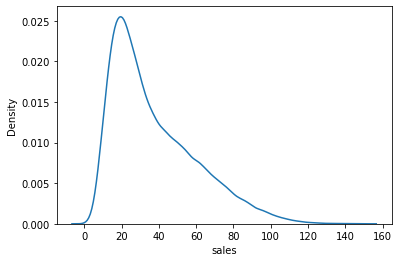

In [ ]:
sns.kdeplot(train['sales'])

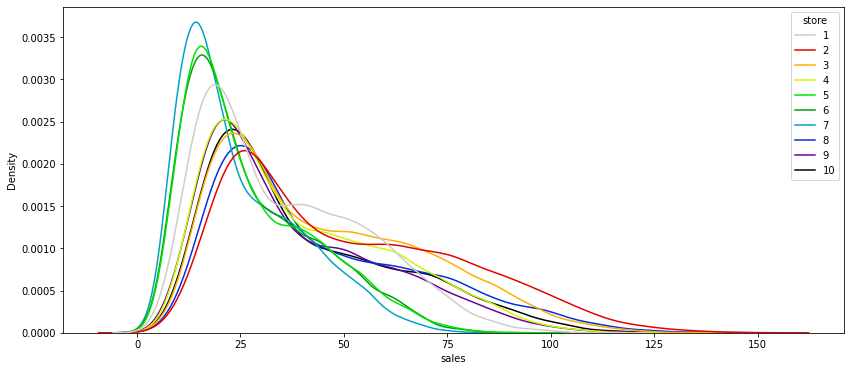

In [ ]:
plt.figure(figsize=(14,6))
sns.kdeplot(train['sales'], hue=train['store'], palette='nipy_spectral_r')

#### Sales occur more b/w 25 and 50
#### More sales occur at store 7 and least at store 2

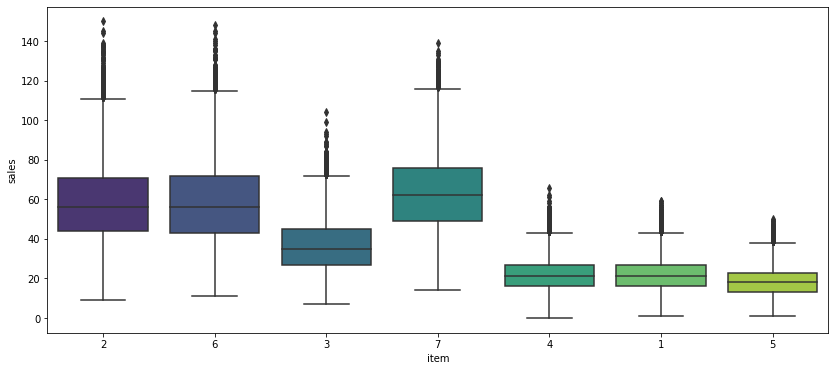

In [ ]:
plt.figure(figsize=(14,6))
plot_order = train.groupby('item')['sales'].sum().sort_values(ascending=False).index.values
sns.boxplot(data=train, x='item', y='sales',order=plot_order, palette='viridis')

#### More sales are from item 15 and less from item 5

In [ ]:
#sales by year
agg_year_item= pd.pivot_table(train, index='year', columns='item', values='sales',aggfunc=np.mean).values
agg_year_store= pd.pivot_table(train, index='year', columns='store', values='sales',aggfunc=np.mean).values

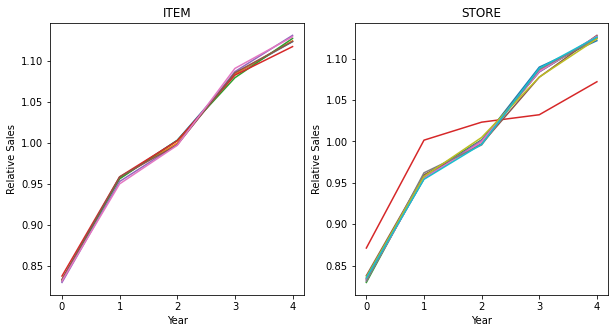

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(agg_year_item/agg_year_item.mean(0)[np.newaxis])
plt.title('ITEM')
plt.ylabel('Relative Sales')
plt.xlabel('Year')
plt.subplot(122)
plt.plot(agg_year_store/agg_year_store.mean(0)[np.newaxis])
plt.title('STORE')
plt.ylabel('Relative Sales')
plt.xlabel('Year')
plt.show()

#### Items and Stores grow over time similiarly

In [ ]:
#sales by month
agg_month_item= pd.pivot_table(train, index='month', columns='item', values='sales',aggfunc=np.mean).values
agg_month_store= pd.pivot_table(train, index='month', columns='store', values='sales',aggfunc=np.mean).values

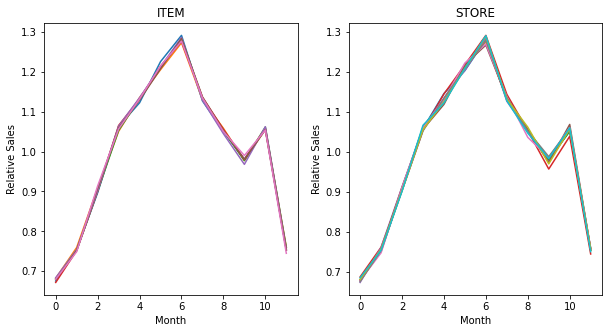

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(agg_month_item/agg_month_item.mean(0)[np.newaxis])
plt.title('ITEM')
plt.ylabel('Relative Sales')
plt.xlabel('Month')
plt.subplot(122)
plt.plot(agg_month_store/agg_month_store.mean(0)[np.newaxis])
plt.title('STORE')
plt.ylabel('Relative Sales')
plt.xlabel('Month')
plt.show()

#### Similiar pattern for both item and store sales

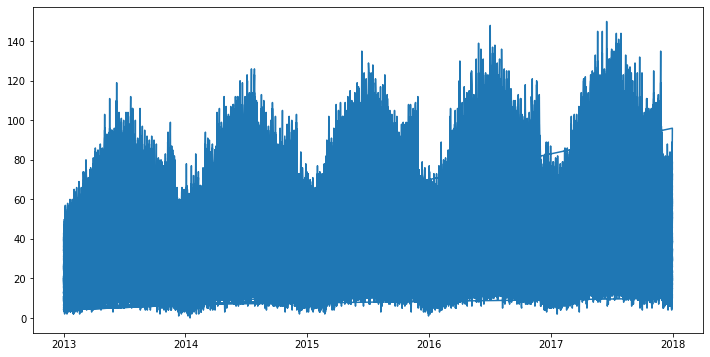

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train['sales'])

In [ ]:
# Resampling to Monthly wise
train_monthly= train.resample('m').mean()
train_monthly.shape

(60, 12)

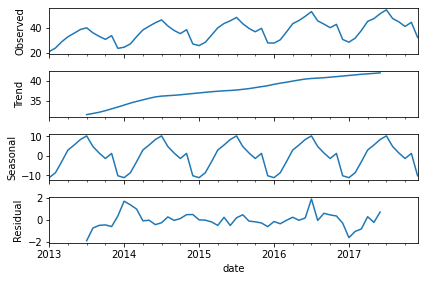

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result= seasonal_decompose(train_monthly['sales'], model='additive')
result.plot();

#### Seems Data is non-stationary
#### Data has clear trend and seasonality.
#### Residuals are decomposing randomly around 0, so the series is additive.

#### ----------------------------------------------------------------------------------------

## Checking for stationarity

### 1) Rolling Mean

In [ ]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

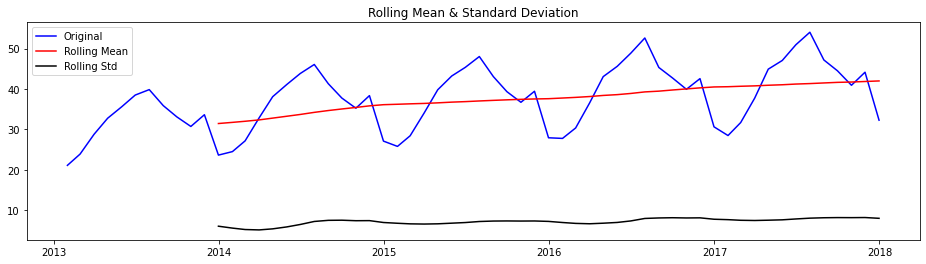

In [ ]:
test_stationarity(train_monthly['sales'])

### 2) ADCF TEST

In [ ]:
#H0-->null hypothesis-->It is non-stationary
#H1-->Alternate hypothesis --> It is stationary
def adfuller_test(timeseries):
    results= adfuller(timeseries)
    labels= ['ADF test statistic', 'p-value','Lags used', 'No.of observations used']
    for value, label in zip(results, labels):
        print(label+ ':' +str(value))
    if results[1]<=0.01:
        print('Strong evidence againt null hypothesis(H1). Its stationary')
    else:
        print('Weak evidence against alternate hypothesis(H1). Its non-stationary')

In [ ]:
adfuller_test(train_monthly['sales'])

ADF test statistic:-5.736278143153922
p-value:6.427360681442051e-07
Lags used:11
No.of observations used:48
Strong evidence againt null hypothesis(H1). Its stationary


### Plotting ACF ANF PACF

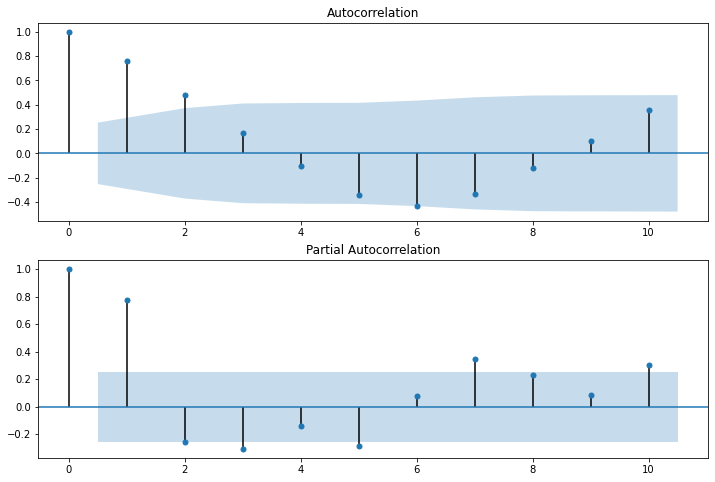

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_monthly['sales'].dropna(), lags=10, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_monthly['sales'].dropna(), lags=10, ax=ax2)

In [ ]:
train1= train_monthly[0:48]
test1= train_monthly[48:]
print('training data:', train1.shape[0])
print('testing data:', test1.shape[0])

training data: 48
testing data: 12


In [ ]:
result_ar= ARIMA(train1['sales'], order=(0,1,1)).fit(disp=False)
result_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                   47
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -139.886
Method:                       css-mle   S.D. of innovations              4.745
Date:                Tue, 27 Apr 2021   AIC                            285.772
Time:                        17:08:56   BIC                            291.322
Sample:                    02-28-2013   HQIC                           287.860
                         - 12-31-2016                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1691      0.795      0.213      0.833      -1.390       1.728
ma.L1.D.sales     0.1514      0.130      1.163      0.251      -0.104       0.407
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -6.6053           +0.0000j            6.6053            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
ar_pred= result_ar.predict(start=48, end=60).rename('AR forecasting')

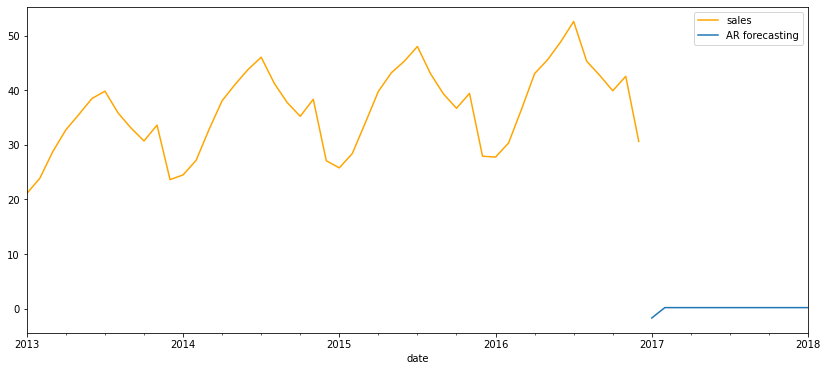

In [ ]:
train1['sales'].plot(figsize=(14,6), legend=True, color='orange')
ar_pred.plot(figsize=(14,6), legend=True)

In [ ]:
result_sarima= sm.tsa.statespace.SARIMAX(train1['sales'], order=(2,1,2), seasonal_order=(2,1,2,4)).fit()
result_sarima.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             sales   No. Observations:                   48
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 4)   Log Likelihood                 -67.922
Date:                           Tue, 27 Apr 2021   AIC                            153.845
Time:                                   17:08:58   BIC                            169.696
Sample:                               01-31-2013   HQIC                           159.690
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2764      1.286      0.215      0.830      -2.243       2.796
ar.L2          0.5141      1.047      0.491      0.623      -1.537       2.566
ma.L1         -0.2589      1.330     -0.195      0.846      -2.865       2.347
ma.L2         -0.7159      1.139     -0.629      0.530      -2.948       1.516
ar.S.L4       -1.0159      0.038    -26.410      0.000      -1.091      -0.941
ar.S.L8       -0.9898      0.010    -96.266      0.000      -1.010      -0.970
ma.S.L4        0.0066      0.424      0.016      0.988      -0.824       0.837
ma.S.L8        0.0471      0.426      0.111      0.912      -0.788       0.882
sigma2         0.6224      0.325      1.913      0.056      -0.015       1.260
===================================================================================
Ljung-Box (Q):                       34.81   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.70   Prob(JB):                         0.76
Heteroskedasticity (H):               1.62   Skew:                            -0.27
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

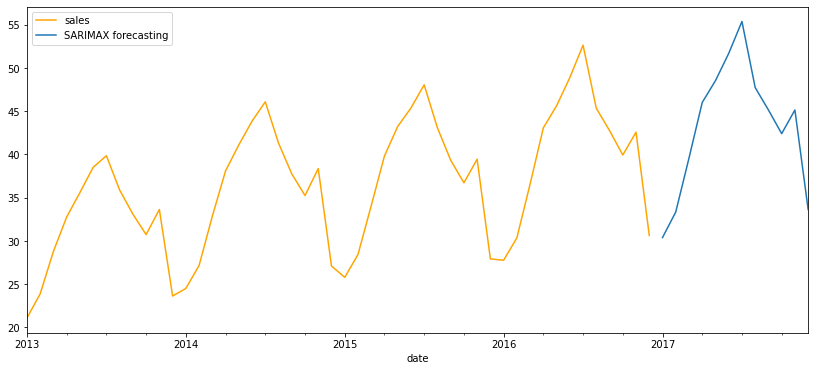

In [ ]:
sar_pred= result_sarima.predict(start=48, end=59).rename('SARIMAX forecasting')
train1['sales'].plot(figsize=(14,6), legend=True, color='orange')
sar_pred.plot(figsize=(14,6), legend=True)

In [ ]:
# creating data for 24 months
from pandas.tseries.offsets import DateOffset
future_dates= [train_monthly.index[-1] + DateOffset(months=x) for x in range(0,24)]
future_data= pd.DataFrame(index=future_dates[1:],columns=train_monthly.columns)
data_concat= pd.concat([train_monthly, future_data])
data_concat.head()

,store,item,sales,month,year,day_of_month,day_of_week,day_of_year,week_of_year,is_weekend,is_startofmonth,is_endofmonth
2013-01-31,5.3125,3.71875,21.095262,1.0,2013.0,16.0,3.903226,16.0,2.870968,0.387097,0.032258,0.032258
2013-02-28,5.3125,3.71875,23.887277,2.0,2013.0,14.5,4.000000,45.5,7.071429,0.428571,0.035714,0.035714
2013-03-31,5.3125,3.71875,28.798387,3.0,2013.0,16.0,4.193548,75.0,11.258065,0.483871,0.032258,0.032258
2013-04-30,5.3125,3.71875,32.766667,4.0,2013.0,15.5,3.833333,105.5,15.666667,0.400000,0.033333,0.033333
2013-05-31,5.3125,3.71875,35.595262,5.0,2013.0,16.0,4.000000,136.0,20.000000,0.419355,0.032258,0.032258


Text(0.5, 1.0, 'Sales for next 12 months[SARIMAX]')

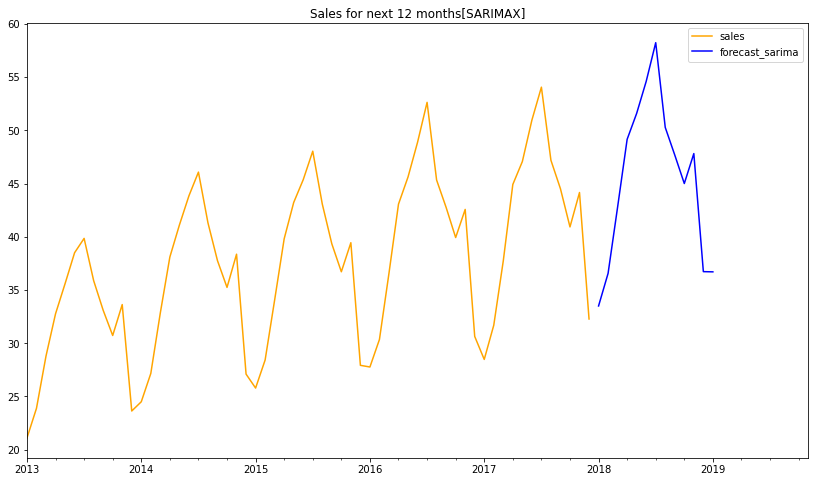

In [ ]:
data_concat['forecast_sarima']=result_sarima.predict(start=60, end=72)
data_concat[['sales','forecast_sarima']].plot(figsize=(14,8), color=['orange','blue'])
plt.title('Sales for next 12 months[SARIMAX]')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
error= mean_squared_error(test1.sales, sar_pred)
error

1.7374438074610927

### SARIMAX is performing better than ARIMA model

## Using LGB

In [ ]:
data.shape

(161006, 14)

In [ ]:
# Sort the values per store, item and date so that values would be shifted equally
data.sort_values(by=['store','item', 'date'], inplace=True, axis=0)

## Features creating from previous sales values

In [ ]:
# Creating sales lag features
def lag_features(dataframe, lags):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + np.random.normal(size=(len(data),))
    return dataframe

In [ ]:
data= lag_features(data, lags=[91,98,105,112,119,126,182,364,546,728])
data.tail()

,date,store,item,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_median_365,sales_roll_median_546,sales_ewm_alpha_095_lag_1,sales_ewm_alpha_09_lag_1,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_07_lag_1,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_119,sales_ewm_alpha_095_lag_126,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_364,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_119,sales_ewm_alpha_09_lag_126,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_364,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_119,sales_ewm_alpha_08_lag_126,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_364,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_119,sales_ewm_alpha_07_lag_126,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_364,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_119,sales_ewm_alpha_05_lag_126,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_364,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44996,2018-03-28,10,50,NaN,44996.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44997,2018-03-29,10,50,NaN,44997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44998,2018-03-30,10,50,NaN,44998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44999,2018-03-31,10,50,NaN,44999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In order to find out possible seasonalities, I will be creating moving averages for specified time intervals. In order to eliminate today's affect on moving average values, I will take 1 shift

In [ ]:
# Creating sales rolling mean features
def roll_mean_features(df, windows):
    df = df.copy()
    for window in windows:
        df['sales_roll_mean_' + str(window)] = df.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type=None).mean()) 
        +np.random.normal(size=(len(data),))
    return df

In [ ]:
data= roll_mean_features(data, windows=[365,546])

In [ ]:
# Creating sales rolling median features
def roll_median_features(df, windows):
    df = df.copy()
    for window in windows:
        df['sales_roll_median_' + str(window)] = df.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type=None).median())
        +np.random.normal(size=(len(data),))
    return df

In [ ]:
data= roll_median_features(data,windows=[365,546])

The value in time t highly depends on the value in time t-1, so in order to have a better prediction, while computing the average value, the values should not be equally weighted.

In [ ]:
# creating sales exponentially weighed mean features
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [ ]:
data= ewm_features(data, alphas = [0.95, 0.9, 0.8, 0.7, 0.5], lags=[91,98,105,112,119,126,182,364,546,728])

In [ ]:
data.shape

(161006, 74)

In [ ]:
data.tail()

,date,store,item,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_median_365,sales_roll_median_546,sales_ewm_alpha_095_lag_1,sales_ewm_alpha_09_lag_1,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_07_lag_1,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_119,sales_ewm_alpha_095_lag_126,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_364,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_119,sales_ewm_alpha_09_lag_126,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_364,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_119,sales_ewm_alpha_08_lag_126,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_364,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_119,sales_ewm_alpha_07_lag_126,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_364,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_119,sales_ewm_alpha_05_lag_126,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_364,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44996,2018-03-28,10,50,NaN,44996.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44997,2018-03-29,10,50,NaN,44997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44998,2018-03-30,10,50,NaN,44998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44999,2018-03-31,10,50,NaN,44999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### One Hot Encoding Some Features

In [ ]:
data= pd.get_dummies(data, columns=['item','store','month','day_of_week'])

In [ ]:
# log tranformation of sales to reduce no.of iterations and there by computation time  
data['sales']= np.log1p(data['sales'].values)
data['sales'].head()

0    2.639057
1    2.484907
2    2.708050
3    2.639057
4    2.397895
Name: sales, dtype: float64

### Train - Validation Split

In [ ]:
#training
train = data.loc[(data["date"] < "2017-01-01"), :]
print(train['date'].min()), print(train['date'].max())

2013-01-01 00:00:00
2016-12-31 00:00:00


(None, None)

In [ ]:
#validation
val = data.loc[(data["date"] >= "2017-01-01") & (data["date"] < "2017-04-01"), :]
print(val['date'].min()), print(val['date'].max())

2017-01-01 00:00:00
2017-03-31 00:00:00


(None, None)

### Custom Cost Function
custom cost function which is based on SMAPE which reverses the log values and calculates the SMAPE.

In [ ]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [ ]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [ ]:
X_train= train[cols]
y_train= train['sales']
X_val= val[cols]
y_val= val['sales']

## Building LGB MODEL

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 15000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)

In [ ]:
lgbval = lgb.Dataset(data=X_val, label=y_val, reference=lgbtrain, feature_name=cols)

In [ ]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=200)

Training until validation scores don't improve for 200 rounds.
[200]	training's l1: 0.160313	training's SMAPE: 16.6128	valid_1's l1: 0.166433	valid_1's SMAPE: 17.2769
[400]	training's l1: 0.15493	training's SMAPE: 16.0703	valid_1's l1: 0.162086	valid_1's SMAPE: 16.8396
[600]	training's l1: 0.152652	training's SMAPE: 15.8398	valid_1's l1: 0.160039	valid_1's SMAPE: 16.6318
[800]	training's l1: 0.151124	training's SMAPE: 15.6851	valid_1's l1: 0.158904	valid_1's SMAPE: 16.5165
[1000]	training's l1: 0.150024	training's SMAPE: 15.5736	valid_1's l1: 0.158117	valid_1's SMAPE: 16.4368
[1200]	training's l1: 0.149193	training's SMAPE: 15.4893	valid_1's l1: 0.157614	valid_1's SMAPE: 16.386
[1400]	training's l1: 0.14851	training's SMAPE: 15.42	valid_1's l1: 0.157269	valid_1's SMAPE: 16.3512
[1600]	training's l1: 0.147918	training's SMAPE: 15.3598	valid_1's l1: 0.156934	valid_1's SMAPE: 16.3173
[1800]	training's l1: 0.14739	training's SMAPE: 15.306	valid_1's l1: 0.156775	valid_1's SMAPE: 16.3013
[20

In [ ]:
y_pred_val= model.predict(X_val)
y_pred_val

array([3.02621962, 2.57991177, 2.72727396, ..., 4.15314862, 4.22172385,
       4.31536991])

In [ ]:
smape(np.expm1(y_pred_val), np.expm1(y_val))

16.19536171725934

In [ ]:
model.best_iteration

4243

In [ ]:
model.best_score

defaultdict(dict,
            {'training': {'SMAPE': 14.825027929665477,
              'l1': 0.14269275288811825},
             'valid_1': {'SMAPE': 16.19536171725934,
              'l1': 0.15572117089964624}})

**Feature Importance**

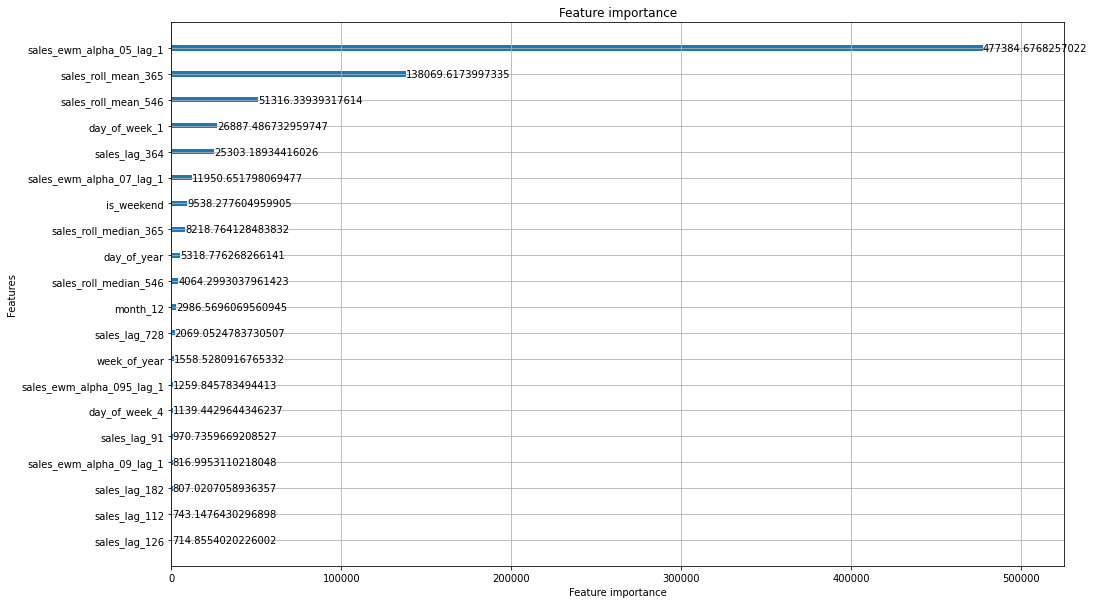

In [ ]:
# this one is the built-in plot function of LightGBM library

lgb.plot_importance(model, max_num_features=20, figsize=(16, 10), importance_type="gain")
plt.show()

In [ ]:
y_pred_val= np.expm1(y_pred_val)
y_pred_val

array([19.61913685, 12.19597386, 14.29114585, ..., 62.63404474,
       67.15086479, 73.84130284])

In [ ]:
y_val= np.expm1(y_val)
y_val

1461      19.0
1462      15.0
1463      10.0
1464      16.0
1465      14.0
          ... 
109280    55.0
109281    72.0
109282    69.0
109283    80.0
109284    68.0
Name: sales, Length: 5670, dtype: float64

In [ ]:
y_val

1461      19.0
1462      15.0
1463      10.0
1464      16.0
1465      14.0
          ... 
109280    55.0
109281    72.0
109282    69.0
109283    80.0
109284    68.0
Name: sales, Length: 5670, dtype: float64